In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import inspect
import os
from ipywidgets import interact, IntSlider, Dropdown, VBox, Output

#### Simple paramters and data points

In [16]:
n = 4
x = np.array([-1/2, -1/6, 1/6, 1/2])
y = np.array([1/4, 1/30, 1/30, 1/4])

#### Helper Functions

In [17]:
def relu(x):
    return np.maximum(0, x)

def indicator(condition):
    return condition.astype(int)

#### 2-layer ReLU neural network

$ f_m(x;\theta) = \frac{1}{\alpha_m} \sum_{j=1}^m a_j(w_j x + b_j)_{+}$

In [18]:
# 2-Lyaer ReLu Neural Network
def twoLayerReluNet(alpha_m, a, w, b, x):
    return 1/alpha_m * np.sum(a * relu(w * x + b))

def network_risk(alpha_m, a, w, b, x, y):
    # Compute wx_plus_b for all i and j
    wx_plus_b = np.outer(x,w) + b  # Shape: (n, m)

    # Apply ReLU
    relu_mask = (wx_plus_b > 0).astype(float)  # Shape: (n, m)
    relu = wx_plus_b * relu_mask  # Apply the mask

      # Shape: (n,)
    return np.mean((1/2)*((np.sum(a * relu, axis=1) / alpha_m) - y) ** 2)

#### Initialisation of weights

$a_j^0 \sim \mathcal{N}(0,\beta^2_{1m})$ and $b_j^0, w_j^0 \sim \mathcal{N}(0,\beta^2_{2m})$

through normalisation we define

$\kappa := \frac{\beta_{1m} \beta_{2m}}{\alpha_m}$, $\kappa' := \frac{\beta_{1m}}{\beta_{2m}}$

and

$\gamma := \lim_{m \rightarrow \infty} \frac{\log{\kappa}}{\log{m}}$, $\gamma' := \lim_{m \rightarrow \infty} \frac{\log{\kappa'}}{\log{m}}$

We take that parameters $a_m, \beta_{1m}, \beta_{2m}$ are taken to have a power-law relation to $m$ and so we are able to choose $\gamma$ and $\gamma'$ such that the $a$-lag training regime is used.

<small>  T. Luo, Z.-Q. J. Xu, Z. Ma, and Y. Zhang. Phase diagram for two-layer relu neu
ral networks at innite-width limit . In: Journal of Machine Learning Research 22.71
 (2021), pp. 147.</small>

<small>  Z.Chen,Y.Li,T.Luo,Z.Zhou,andZ.-Q. J. Xu. Phase diagram of initial condensation
 for two-layer neural networks . In: arXiv preprint arXiv:2303.06561 (2023).</small>

In [19]:
## We use the following to fix the values of gamma, gamma_prime and alpha_m
gamma = 3/2
gamma_prime = -1/2

def generate_alpha_betas(m):
    alpha_m = m**(gamma - gamma_prime)
    kappa = m**(-gamma)
    kappa_prime = m**(-gamma_prime)

    beta_1m = math.sqrt(kappa*kappa_prime*alpha_m)
    beta_2m = math.sqrt((kappa/kappa_prime)*alpha_m)

    return alpha_m, beta_1m, beta_2m

#### Gradient flow

Empirical Risk equation - $\mathcal{R}(\theta) := \frac{1}{2n} \sum_{i=1}^m (f_m(x_i; \theta) - y_i)^2$

In [20]:
## Typical parameter gradients
def gradient_flow(a,w,b,alpha_m):
    # Compute wx_plus_b for all i and j
    wx_plus_b = np.outer(x,w) + b  # Shape: (n, m)

    # Apply ReLU activation
    relu_mask = (wx_plus_b > 0).astype(float)  # Shape: (n, m)
    relu = wx_plus_b * relu_mask  # Apply the mask

    # First term inside parentheses: (1 / alpha_m) * sum_j(a_j * ReLU_j)
    term2 = (np.sum(a * relu, axis=1) / alpha_m) - y  # Shape: (n,)

    # Full sum: sum relu multiplied with appropriate term2, over i
    full_sum_a = np.sum(relu * term2[:, np.newaxis], axis=0)  # Shape: (m,)

    # Multiply by aj * xi * 1{wx_plus_b > 0}
    term1_w = (a * x[:, np.newaxis] * relu_mask)  # Shape: (n, m)
    # Full sum: sum term1_w multiplied with appropriate term2, over i
    full_sum_w = np.sum(term1_w * term2[:, np.newaxis], axis=0)  # Shape: (m,)

    # Multiply by aj * 1{wx_plus_b > 0}
    term1_b = (a * relu_mask)  # Shape: (n, m)
    # Full sum: sum term1_b multiplied with appropriate term2, over i
    full_sum_b = np.sum(term1_b * term2[:, np.newaxis], axis=0)  # Shape: (m,)

    # Scale by constants
    grad_a = -full_sum_a / (n * alpha_m)  # Final shape: (m,)
    grad_w = -full_sum_w / (n * alpha_m)  # Final shape: (m,)
    grad_b = -full_sum_b / (n * alpha_m)  # Final shape: (m,)

    return grad_a, grad_w, grad_b

Gradient Descent training

In [21]:
def gradient_descent(step_size, steps, m, symmetric=False):

    alpha_m, beta_1m, beta_2m = generate_alpha_betas(m)

    m_len = math.ceil(m / 2) if symmetric else math.ceil(m)    

    a = np.random.normal(loc=0, scale=beta_1m, size=m_len)
    w = np.random.normal(loc=0, scale=beta_2m, size=m_len)
    b = np.random.normal(loc=0, scale=beta_2m, size=m_len)

    if symmetric:
        a = np.concatenate((a, a))
        w = np.concatenate((w, -w))
        b = np.concatenate((b, b))

    a_values = []
    w_values = []
    b_values = []

    #for n in range(math.ceil(time/step_size)):
    for n in range(steps): 
        grad_a, grad_w, grad_b = gradient_flow(a,w,b,alpha_m)
        a = a + step_size * grad_a
        w = w + step_size * grad_w
        b = b + step_size * grad_b

        # Save the current values of a, w, and b
        a_values.append(a.copy())
        w_values.append(w.copy())
        b_values.append(b.copy())

    return a_values, w_values, b_values



#### Training

In [22]:
def train(m_values, n_steps, learning_rate):
    for m in m_values:
        a_values, w_values, b_values = gradient_descent(learning_rate, n_steps, m, True)

        # Convert lists to arrays for easier saving and plotting
        a_values = np.array(a_values)
        w_values = np.array(w_values)
        b_values = np.array(b_values)

        # Save the arrays to disk
        np.save('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), a_values)
        np.save('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), w_values)
        np.save('weights\\b_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), b_values)

        print(f'Completed training for steps: {n_steps}, learning rate: {learning_rate}, m value: {m}')

Code Cell generating min and max y values over time

In [39]:
# Define the function to plot the values at a given index
def get_values(x_graph, a_vals, w_vals, b_vals, alpha_m, index):
    a = a_vals[index]
    w = w_vals[index]
    b = b_vals[index]
    
    y_graph = np.zeros((int)(400)) # TODO: Try to remove this, initialising it each time is slow

    # Compute the corresponding y values
    for i in range(len(x_graph)):
        y_graph[i] = twoLayerReluNet(alpha_m,a,w,b,x_graph[i])

    return np.min(y_graph), np.max(y_graph)

def gen_or_load_y_max_min_pts(x_graph, m, learning_rate, n_steps, index_refinment):
    y_min_file = 'graphing_values\\y_max_min\\y_min_m%d_Learning%d_Steps%d_Refinment%d.npy' % (m, learning_rate, n_steps, index_refinment)
    y_max_file = 'graphing_values\\y_max_min\\y_max_m%d_Learning%d_Steps%d_Refinment%d.npy' % (m, learning_rate, n_steps, index_refinment)

    if os.path.exists(y_min_file) and os.path.exists(y_max_file):
        print(f'Loading min and max values for m={m}, learning rate={learning_rate}, steps={n_steps}, refinement={index_refinment}')
        return np.load(y_min_file), np.load(y_max_file)

    # Load the arrays from disk
    a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    b_values = np.load('weights\\b_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

    alpha_m = generate_alpha_betas(m)[0]

    min_y_values = np.zeros((int)(n_steps/index_refinment))
    max_y_values = np.zeros((int)(n_steps/index_refinment))
    # Load min and max values obtained by graph at index
    for n in range((int)(n_steps/index_refinment)):
        min_y_values[n], max_y_values[n] = get_values(x_graph, a_values, w_values, b_values, alpha_m, n*index_refinment)

    # Save the arrays to disk
    np.save(y_min_file, min_y_values)
    np.save(y_max_file, max_y_values)

    return min_y_values, max_y_values

def generate_y_max_min_plot(m_values, n_steps, learning_rate, index_refinment, scaling_func):

    scale_text = inspect.getsource(scaling_func).strip()
    scale_text = scale_text[scale_text.find(":")+2:-1]

    # There could be too many points, so we only take every index_refinment points when needed to increase speed
    # About 1 minute for 200k steps, refinement of 50 and m_values = [200, 400, 600, 800, 1000]

    # x values for the graph
    x_graph = np.linspace(-0.5, 0.5, 400)

    # Create an array of indices
    indices = np.arange(n_steps/index_refinment)

    # Generate a colormap
    colormap = cm.get_cmap('viridis', len(m_values))

    plt.figure(figsize=(10, 6))

    for idx, m in enumerate(m_values):
        min_y_values, max_y_values = gen_or_load_y_max_min_pts(x_graph, m, learning_rate, n_steps, index_refinment)

        # Plot the min and max values
        plt.plot(indices*scaling_func(m), min_y_values, color=colormap(idx))
        plt.plot(indices*scaling_func(m), max_y_values, color=colormap(idx))

        # Attach label
        plt.plot([], [], color=colormap(idx), label=f'm = {m}')

    filename = f'YMinMax_Scale{scale_text}_M{m_values}_Learning{learning_rate}_Steps{n_steps}.svg'

    # Sanitize the file name by replacing invalid characters
    invalid_chars = ['/', '\\', ':', '*', '?', '"', '<', '>', '|']
    for char in invalid_chars:
        filename = filename.replace(char, "_")

    folder_path = f'figs\\y_min_max\\learning{learning_rate}\\'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.yscale('log')
    plt.xlabel(f'Index x{index_refinment} with scaling {scale_text}')
    plt.ylabel('y values')
    plt.title('Min and Max y values at index') # TODO: Recheck the text for labels and title
    plt.xlim(0, 1e-5)
    plt.legend()
    plt.grid(True)
    plt.savefig(folder_path+filename)
    plt.show()
    print(f'Completed plotting for steps: {n_steps}, learning rate: {learning_rate}, m values: {m_values}, rescale: {scale_text}')

In [49]:
# Define the function to plot the values at a given index
def get_risk(a_vals, w_vals, b_vals, alpha_m, index):
    a = a_vals[index]
    w = w_vals[index]
    b = b_vals[index]
    
    return network_risk(alpha_m, a, w, b, x, y)

def gen_or_load_risk_pts(m, learning_rate, n_steps, index_refinment):
    risk_file = 'graphing_values\\risk\\risk_m%d_Learning%d_Steps%d_Refinment%d.npy' % (m, learning_rate, n_steps, index_refinment)

    if os.path.exists(risk_file):
        print(f'Loading risk values for m={m}, learning rate={learning_rate}, steps={n_steps}, refinement={index_refinment}')
        return np.load(risk_file)

    # Load the arrays from disk
    a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    b_values = np.load('weights\\b_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

    alpha_m = generate_alpha_betas(m)[0]

    risk = np.zeros((int)(n_steps/index_refinment))
    # Load min and max values obtained by graph at index
    for n in range((int)(n_steps/index_refinment)):
        risk[n] = get_risk(a_values, w_values, b_values, alpha_m, n*index_refinment)

    # Save the arrays to disk
    np.save(risk_file, risk)

    return risk

def generate_risk_plot(m_values, n_steps, learning_rate, index_refinment, scaling_func):

    scale_text = inspect.getsource(scaling_func).strip()
    scale_text = scale_text[scale_text.find(":")+2:-1]

    # There could be too many points, so we only take every index_refinment points when needed to increase speed
    # About 1 minute for 200k steps, refinement of 50 and m_values = [200, 400, 600, 800, 1000]

    # Create an array of indices
    indices = np.arange(n_steps/index_refinment)

    # Generate a colormap
    colormap = cm.get_cmap('viridis', len(m_values))

    plt.figure(figsize=(10, 6))

    for idx, m in enumerate(m_values):
        risk = gen_or_load_risk_pts(m, learning_rate, n_steps, index_refinment)

        # Plot the min and max values
        plt.plot(indices*scaling_func(m), risk, color=colormap(idx))

        # Attach label
        plt.plot([], [], color=colormap(idx), label=f'm = {m}')

    filename = f'RiskPlot_Scale{scale_text}_M{m_values}_Learning{learning_rate}_Steps{n_steps}.svg'

    # Sanitize the file name by replacing invalid characters
    invalid_chars = ['/', '\\', ':', '*', '?', '"', '<', '>', '|']
    for char in invalid_chars:
        filename = filename.replace(char, "_")

    folder_path = f'figs\\risk\\learning{learning_rate}\\'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.yscale('log')
    plt.xlabel(f'Index x{index_refinment} with scaling {scale_text}')
    plt.ylabel('risk')
    plt.xlim(0, 1e-5)
    plt.ylim(1e-4, 1e-1)
    plt.title('Risk at index') # TODO: Recheck the text for labels and title
    plt.legend()
    plt.grid(True)
    plt.savefig(folder_path+filename)
    plt.show()
    print(f'Completed plotting for steps: {n_steps}, learning rate: {learning_rate}, m values: {m_values}, rescale: {scale_text}')

Generate and save all weights and graphs

C:\Users\malco\AppData\Local\Temp\ipykernel_30356\2429294935.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(m_values))


Loading min and max values for m=200, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=400, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=600, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=800, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=1000, learning rate=4000, steps=200000, refinement=25


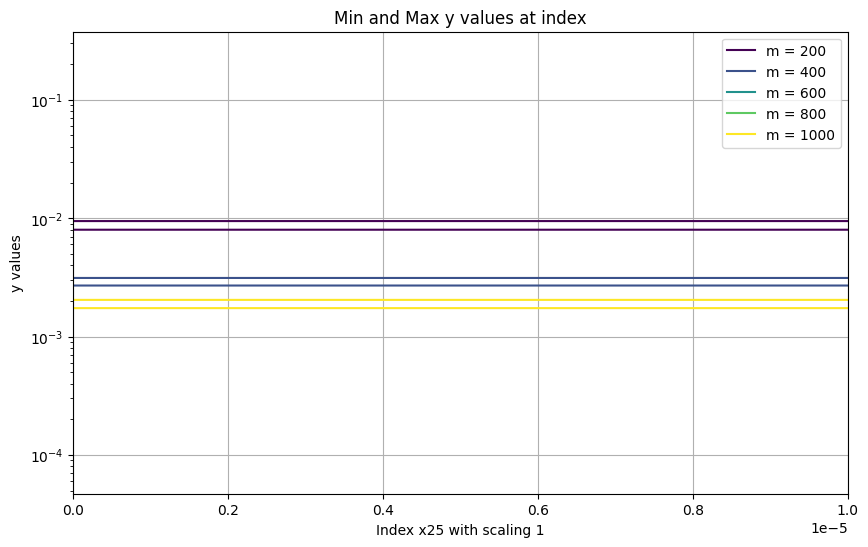

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: 1
Loading min and max values for m=200, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=400, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=600, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=800, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=1000, learning rate=4000, steps=200000, refinement=25


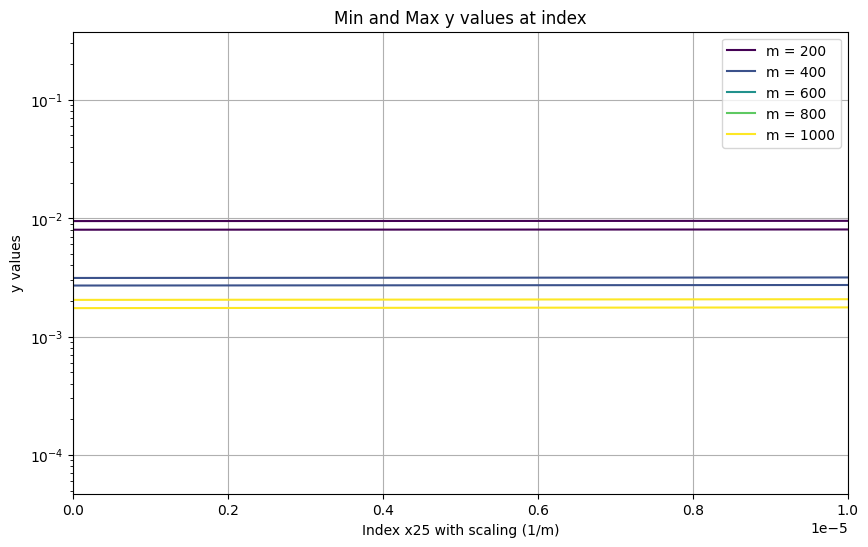

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/m)
Loading min and max values for m=200, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=400, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=600, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=800, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=1000, learning rate=4000, steps=200000, refinement=25


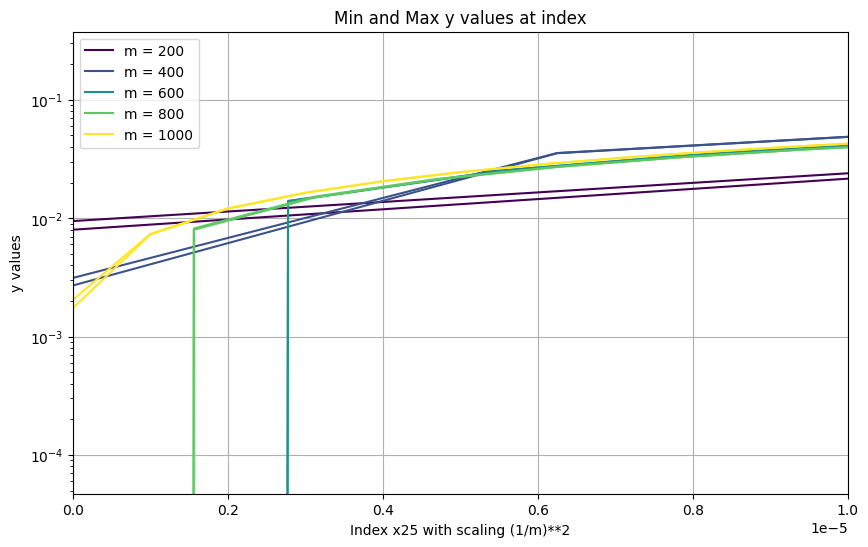

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/m)**2
Loading min and max values for m=200, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=400, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=600, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=800, learning rate=4000, steps=200000, refinement=25
Loading min and max values for m=1000, learning rate=4000, steps=200000, refinement=25


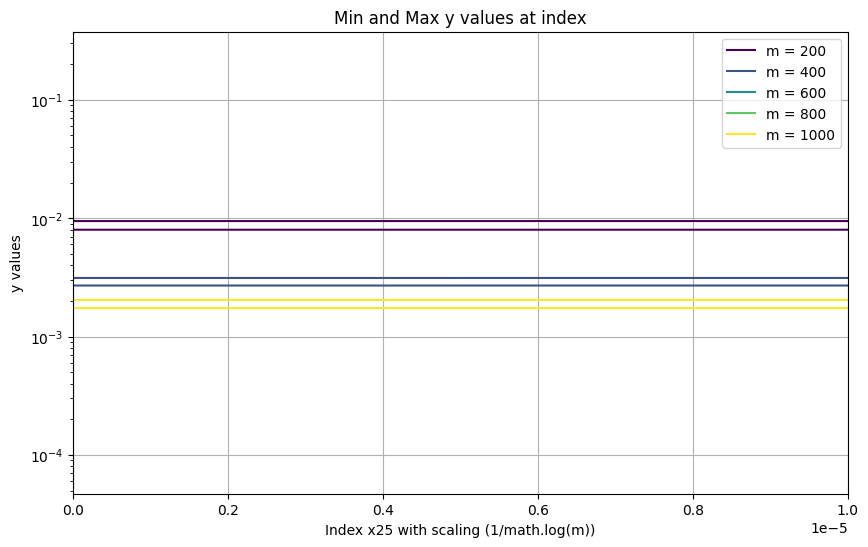

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/math.log(m))
Loading risk values for m=200, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=400, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=600, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=800, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=1000, learning rate=4000, steps=200000, refinement=25


C:\Users\malco\AppData\Local\Temp\ipykernel_30356\1036293242.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(m_values))


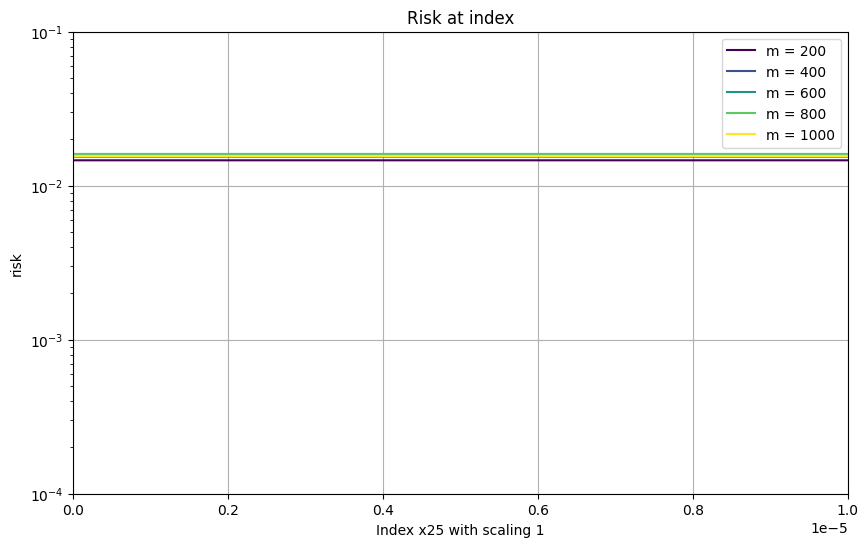

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: 1
Loading risk values for m=200, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=400, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=600, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=800, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=1000, learning rate=4000, steps=200000, refinement=25


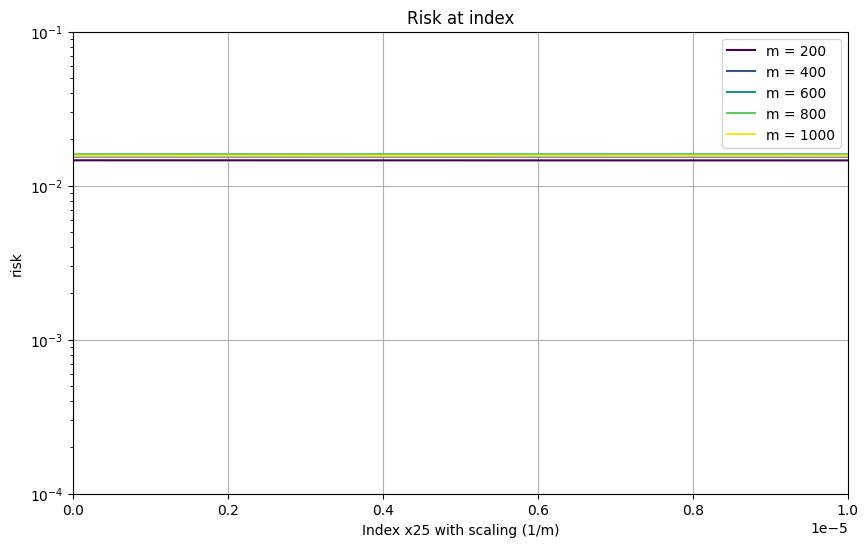

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/m)
Loading risk values for m=200, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=400, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=600, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=800, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=1000, learning rate=4000, steps=200000, refinement=25


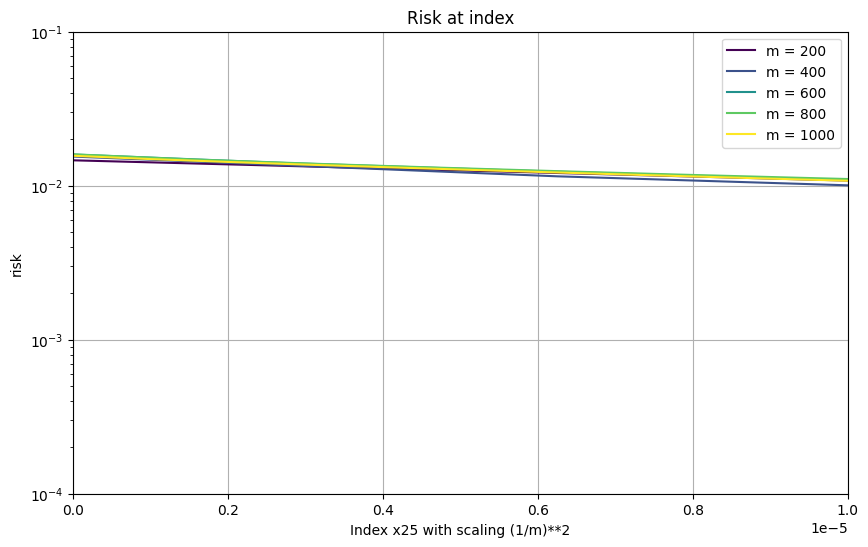

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/m)**2
Loading risk values for m=200, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=400, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=600, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=800, learning rate=4000, steps=200000, refinement=25
Loading risk values for m=1000, learning rate=4000, steps=200000, refinement=25


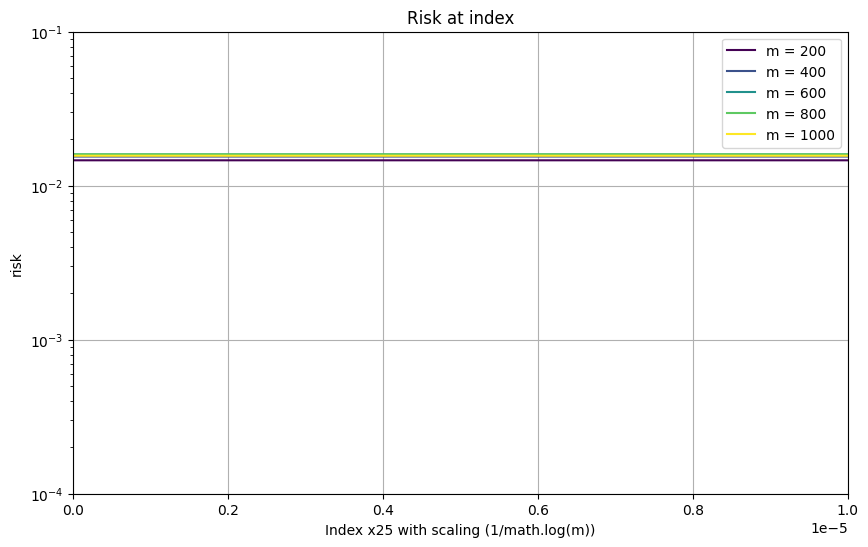

Completed plotting for steps: 200000, learning rate: 4000, m values: [ 200  400  600  800 1000], rescale: (1/math.log(m))


In [50]:
def gen_graphs(m_values, n_steps, learning_rate, index_refinment):
    generate_y_max_min_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: 1)
    generate_y_max_min_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/m))
    generate_y_max_min_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/m)**2)
    generate_y_max_min_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/math.log(m)))

    generate_risk_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: 1)
    generate_risk_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/m))
    generate_risk_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/m)**2)
    generate_risk_plot(m_values, n_steps, learning_rate, index_refinment, lambda m: (1/math.log(m)))

m_values = np.array([200, 400, 600, 800, 1000])

## Learning rate of 4000

n_steps = 200000
learning_rate = 4000
# train(m_values, n_steps, learning_rate)
gen_graphs(m_values, n_steps, learning_rate, 25)

## Learning rate of 2000

n_steps = 250000
learning_rate = 2000
# train(m_values, n_steps, learning_rate)
# gen_graphs(m_values, n_steps, learning_rate, 25)


## Learning rate of 1000

n_steps = 300000
learning_rate = 1000
# train(m_values, n_steps, learning_rate)
# gen_graphs(m_values, n_steps, learning_rate, 25)


## Learning rate of 4000 but very small m

m_values = [40, 60, 80, 100, 120]
n_steps = 2200
learning_rate = 4000
# train(m_values, n_steps, learning_rate)
# gen_graphs(m_values, n_steps, learning_rate, 1)

Code Cell generating function development over time - Used for testing analysis

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown, VBox

# Define the range of x
x_graph = np.linspace(-0.5, 0.5, 800)

# Global variables to hold the current state
current_m = None
current_a_values = None
current_w_values = None
current_b_values = None

# Output widget for displaying the plot
output = Output()

m_values = [200,400,600,800,1000]
n_steps = 200000

# m_values = [40, 60, 80, 100, 120]
# n_steps = 2200

learning_rate = 4000

def load_data_for_m(m):
    """Load data for a specific m and keep only the current m's data in memory."""
    global current_m, current_a_values, current_w_values, current_b_values

    # If m has not changed, skip loading
    if m == current_m:
        return

    # Load new data for m
    current_a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    current_w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    current_b_values = np.load('weights\\b_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    current_m = m

def plot_values(m, index):
    """Plot the function for the selected m and index."""
    # Ensure data for the selected m is loaded
    load_data_for_m(m)
    a = current_a_values[index]
    w = current_w_values[index]
    b = current_b_values[index]

    alpha_m = generate_alpha_betas(m)[0]

    # Compute the corresponding y values
    y_graph = np.array([twoLayerReluNet(alpha_m, a, w, b, x) for x in x_graph])

     # Clear the previous plot and create a new one
    with output:
        output.clear_output(wait=True)
        plt.scatter(x, y, c='orange', alpha=0.5, label='Data points')
        plt.plot(x_graph, y_graph, label=f'm={m}, index={index}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)
        plt.xlim(-0.6, 0.6)
        plt.ylim(-0.01, 0.3)
        plt.show()

# Create dropdown and slider widgets
m_dropdown = Dropdown(
    options=m_values,  # Update with the range of available m values
    value=m_values[0],
    description='m',
)

index_slider = IntSlider(
    min=0,
    max=0,  # This will be dynamically updated
    step=1,
    value=0,
    description='Index',
)

# Function to update the slider when m changes
def on_m_change(change):
    m = change['new']
    load_data_for_m(m)
    index_slider.max = len(current_a_values) - 1
    index_slider.value = 0

# Function to update the plot when slider or dropdown changes
def on_index_change(change):
    plot_values(m_dropdown.value, index_slider.value)

# Link dropdown and slider to their respective update functions
m_dropdown.observe(on_m_change, names='value')
index_slider.observe(on_index_change, names='value')

# Display widgets and the output plot
display(VBox([m_dropdown, index_slider, output]))

# Initialize the plot
plot_values(m_dropdown.value, index_slider.value)

In [28]:
# Load new data for m
m = 1000
learning_rate = 4000
n_steps = 200000

current_a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d_not_symmetric.npy' % (m, learning_rate, n_steps))
current_w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d_not_symmetric.npy' % (m, learning_rate, n_steps))
current_b_values = np.load('weights\\b_values_m%d_Learning%d_Steps%d_not_symmetric.npy' % (m, learning_rate, n_steps))

x_graph = np.linspace(-0.5, 0.5, 800)

output = Output()

def plot_values(index):
    """Plot the function for the selected m and index."""
    # Ensure data for the selected m is loaded

    a = current_a_values[index]
    w = current_w_values[index]
    b = current_b_values[index]

    alpha_m = generate_alpha_betas(m)[0]

    # Compute the corresponding y values
    y_graph = np.array([twoLayerReluNet(alpha_m, a, w, b, x) for x in x_graph])

     # Clear the previous plot and create a new one
    with output:
        output.clear_output(wait=True)
        plt.scatter(x, y, c='orange', alpha=0.5, label='Data points')
        plt.plot(x_graph, y_graph, label=f'm={m}, index={index}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)
        plt.xlim(-0.6, 0.6)
        plt.ylim(-0.01, 0.3)
        plt.show()

# Create a slider for selecting the index
slider = IntSlider(min=0, max=len(current_a_values)-1, step=1, value=0, description='Index')

# Use interact to create an interactive plot
interact(plot_values, index=slider)

# Display the output widget
display(output)

interactive(children=(IntSlider(value=0, description='Index', max=199999), Output()), _dom_classes=('widget-in…

Output()